# **Risk Modeling**

Radyatra Sidharta

## I. Table of Content

- II. Library Import

- III. Loading Data

- IV. Exploratory Data Analysis (EDA)

- V. Data Preprocessing
    - a. Outlier Handling
    - b. Feature Encoding
    - c. Feature Scaling
    - d. Concat
    - e. PCA

- VI. K-Means Clustering

- VII. Spectral Clustering

- VIII. BIRCH

- IX. Model Pipeline & Inference

- X. Model Saving

- XI. Conclusion


## II. Library Import

In [57]:
# Define Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pickle

import warnings
warnings.filterwarnings('ignore')

# For Feature Encoding
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# For Feature Scaling
from sklearn.preprocessing import MinMaxScaler

# For Principal Component Analysis
from sklearn.decomposition import PCA

# For Models
from sklearn.cluster import KMeans, SpectralClustering, Birch

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

np.random.seed(42)

## III. Loading Data

In [3]:
# Syntax for reading excel file.
df = pd.read_excel('IndonesiaCreditData.xlsx', sheet_name="Dataset")
df

,No,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,14494431,6,radio/TV
1,1,22,female,2,own,little,moderate,73786449,48,radio/TV
2,2,49,male,1,own,little,NaN,25988304,12,education
3,3,45,male,2,free,little,little,97728918,42,furniture/equipment
4,4,53,male,2,free,little,little,60383130,24,car
...,...,...,...,...,...,...,...,...,...,...
995,995,31,female,1,own,little,NaN,21524664,12,furniture/equipment
996,996,40,male,3,own,little,little,47822943,30,car
997,997,38,male,2,own,little,NaN,9968796,12,radio/TV
998,998,23,male,2,free,little,little,22876155,45,radio/TV


## IV. Exploratory Data Analysis

In [4]:
# Syntax for detecting the NaNs in our dataset.
df.isnull().sum().sort_values(ascending=False).head(45)

Checking account    394
Saving accounts     183
No                    0
Age                   0
Sex                   0
Job                   0
Housing               0
Credit amount         0
Duration              0
Purpose               0
dtype: int64

In [5]:
# Additional forms of anomalies that we need to detect in our dataset.
anomalous_entries = {}

for x in list(df.columns):
    anomalous_entries[x] = 0
    for y in df[x]:
        if y in ['NaN', 'N/A', '--', '-', 'Null', '?', ' ']: # These are the specific NaN values we will be looking for.
            anomalous_entries[x] = anomalous_entries[x] + 1

anomalous_entries

{'No': 0,
 'Age': 0,
 'Sex': 0,
 'Job': 0,
 'Housing': 0,
 'Saving accounts': 0,
 'Checking account': 0,
 'Credit amount': 0,
 'Duration': 0,
 'Purpose': 0}

In [6]:
# Detecting duplicates in our data.
df_dupl = df.duplicated()
df_dupl.sort_values(ascending=False) 

0      False
671    False
658    False
659    False
660    False
       ...  
338    False
339    False
340    False
341    False
999    False
Length: 1000, dtype: bool

In [7]:
# Identifying unique values in our columns / features.
df['Housing'].unique()

array(['own', 'free', 'rent'], dtype=object)

In [8]:
df['Saving accounts'].unique()

array([nan, 'little', 'quite rich', 'rich', 'moderate'], dtype=object)

In [9]:
df['Checking account'].unique()

array(['little', 'moderate', nan, 'rich'], dtype=object)

In [10]:
df['Duration'].unique()

array([ 6, 48, 12, 42, 24, 36, 30, 15,  9, 10,  7, 60, 18, 45, 11, 27,  8,
       54, 20, 14, 33, 21, 16,  4, 47, 13, 22, 39, 28,  5, 26, 72, 40],
      dtype=int64)

In [11]:
df['Purpose'].unique()

array(['radio/TV', 'education', 'furniture/equipment', 'car', 'business',
       'domestic appliances', 'repairs', 'vacation/others'], dtype=object)

In [12]:
# Replacing NaNs with string.
df1 = df.replace(np.nan, 'none')
df1

,No,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,none,little,14494431,6,radio/TV
1,1,22,female,2,own,little,moderate,73786449,48,radio/TV
2,2,49,male,1,own,little,none,25988304,12,education
3,3,45,male,2,free,little,little,97728918,42,furniture/equipment
4,4,53,male,2,free,little,little,60383130,24,car
...,...,...,...,...,...,...,...,...,...,...
995,995,31,female,1,own,little,none,21524664,12,furniture/equipment
996,996,40,male,3,own,little,little,47822943,30,car
997,997,38,male,2,own,little,none,9968796,12,radio/TV
998,998,23,male,2,free,little,little,22876155,45,radio/TV


## V. Data Preprocessing

### a. Outlier Handling

In [13]:
# Splitting dataframe into three categories: Categorical (Nominal), Categorical (Ordinal), and Numerical
df_nominal = df1[['Sex', 'Housing', 'Purpose']]
df_ordinal = df1[['Saving accounts', 'Checking account']]
df_num = df1[['Age', 'Credit amount', 'Duration']]

In [14]:
# Syntax to create histogram and boxplot.
def diagnostic_plots(df_num, variable):
    # Defining Figure Size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df_num[variable], bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(df_num[variable])
    plt.title('Boxplot')

    plt.show()

    # Skewness
    print('\nSkewness Value : ', df_num[variable].skew())

    # Kurtosis
    print('\nKurtosis Value : ', df_num[variable].kurtosis())

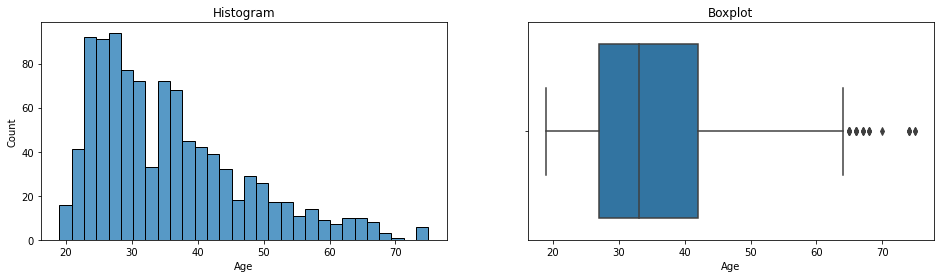


Skewness Value :  1.0207392686768317

Kurtosis Value :  0.5957795670766881


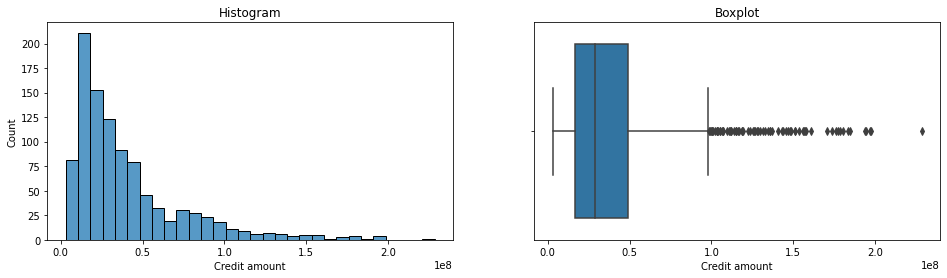


Skewness Value :  1.9496276798326202

Kurtosis Value :  4.292590308048505


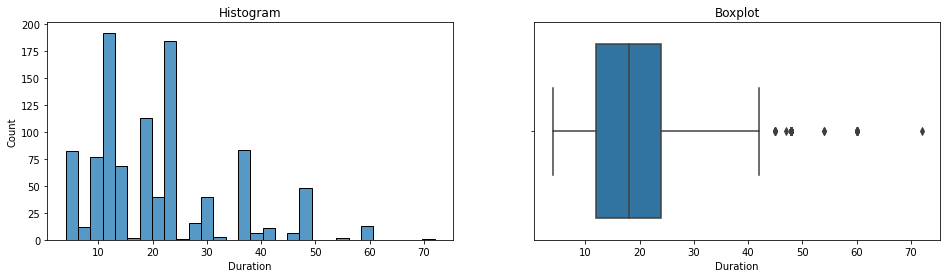


Skewness Value :  1.0941841715555418

Kurtosis Value :  0.9197813600546372


In [15]:
# For loop to create visualization for numerical features.
for variable in df_num.columns:
    diagnostic_plots(df_num,variable)

### b. Feature Encoding

In [16]:
# Defining the Encoders to be used.
ordinal_encoder = OrdinalEncoder()
nominal_encoder = OneHotEncoder()

In [17]:
df_ordinal['Saving accounts'].unique()

array(['none', 'little', 'quite rich', 'rich', 'moderate'], dtype=object)

In [18]:
df_ordinal['Checking account'].unique()

array(['little', 'moderate', 'none', 'rich'], dtype=object)

In [19]:
df_ordinal_encoded = df_ordinal.copy()

In [20]:
# Changing the names of the Saving and checking accounts category into numbers.
df_ordinal_encoded.loc[df_ordinal_encoded['Saving accounts']== 'none', 'Saving accounts'] = 0
df_ordinal_encoded.loc[df_ordinal_encoded['Saving accounts']== 'little', 'Saving accounts'] = 1
df_ordinal_encoded.loc[df_ordinal_encoded['Saving accounts']== 'moderate', 'Saving accounts'] = 2
df_ordinal_encoded.loc[df_ordinal_encoded['Saving accounts']== 'quite rich', 'Saving accounts'] = 3
df_ordinal_encoded.loc[df_ordinal_encoded['Saving accounts']== 'rich', 'Saving accounts'] = 4

df_ordinal_encoded.loc[df_ordinal_encoded['Checking account']== 'none', 'Checking account'] = 0
df_ordinal_encoded.loc[df_ordinal_encoded['Checking account']== 'little', 'Checking account'] = 1
df_ordinal_encoded.loc[df_ordinal_encoded['Checking account']== 'moderate', 'Checking account'] = 2
df_ordinal_encoded.loc[df_ordinal_encoded['Checking account']== 'rich', 'Checking account'] = 3
# Note that the output of these numbers will be in float type.

In [21]:
# Converting float numbers to integer. 
df_ordinal_encoded['Saving accounts'] = df_ordinal_encoded['Saving accounts'].astype(int)
df_ordinal_encoded['Checking account'] = df_ordinal_encoded['Checking account'].astype(int)
df_ordinal_encoded.dtypes

Saving accounts     int32
Checking account    int32
dtype: object

In [22]:
df_ordinal.head(5)

,Saving accounts,Checking account
0,none,little
1,little,moderate
2,little,none
3,little,little
4,little,little


In [23]:
# Comparison
df_ordinal_encoded.head(5)

,Saving accounts,Checking account
0,0,1
1,1,2
2,1,0
3,1,1
4,1,1


In [24]:
# Encoding nominal dataframe
df_nominal_encoded = pd.DataFrame(nominal_encoder.fit_transform(df_nominal).toarray())
df_nominal_encoded.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### c. Feature Scaling

In [25]:
# Defining scaler.
scaler = MinMaxScaler()

# Scaling.
df_num_scaled = pd.DataFrame(scaler.fit_transform(df_num))

In [26]:
df_num_scaled

,0,1,2
0,0.857143,0.050567,0.029412
1,0.053571,0.313690,0.647059
2,0.535714,0.101574,0.117647
3,0.464286,0.419941,0.558824
4,0.607143,0.254209,0.294118
...,...,...,...
995,0.214286,0.081765,0.117647
996,0.375000,0.198470,0.382353
997,0.339286,0.030483,0.117647
998,0.071429,0.087763,0.602941


### d. Concat

In [27]:
# Concat / rejoining scaled and encoded data.
df_final = pd.concat([df_ordinal_encoded.reset_index(drop=True), df_nominal_encoded.reset_index(drop=True), df_num_scaled.reset_index(drop=True)],axis=1)
df_final

,Saving accounts,Checking account,0,1,2,3,4,5,6,7,8,9,10,11,12,0,1,2
0,0,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.857143,0.050567,0.029412
1,1,2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.053571,0.313690,0.647059
2,1,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.535714,0.101574,0.117647
3,1,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.464286,0.419941,0.558824
4,1,1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.607143,0.254209,0.294118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.214286,0.081765,0.117647
996,1,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.375000,0.198470,0.382353
997,1,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.339286,0.030483,0.117647
998,1,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.071429,0.087763,0.602941


### e. PCA

In [28]:
df_final.shape

(1000, 18)

In [29]:
# Defining PCA.
pca = PCA(n_components = 18)
pca.fit(df_final)

PCA(n_components=18)

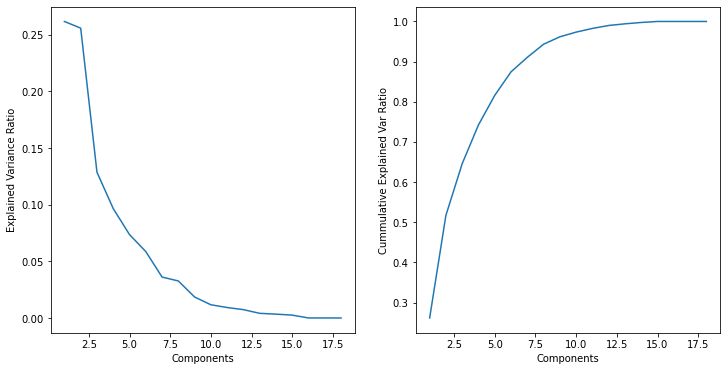

In [30]:
# Visualizing Explained Variance Ratio and Cumulative Explained Variance Ratio.
fig,ax=plt.subplots(ncols=2,figsize=(12,6))
ax[0].plot(range(1,19),pca.explained_variance_ratio_)
ax[0].set_xlabel('Components')
ax[0].set_ylabel('Explained Variance Ratio')

ax[1].plot(range(1,19),np.cumsum(pca.explained_variance_ratio_))
ax[1].set_xlabel('Components')
ax[1].set_ylabel('Cummulative Explained Var Ratio')
plt.show()

In [31]:
# Choosing new n_components and fitting data.
pca2 = PCA(n_components = 7)
pca2.fit(df_final)

PCA(n_components=7)

In [32]:
# Transforming dataset.
X = pca2.transform(df_final)
X.shape

(1000, 7)

## VI. K-Means Clustering

### a. Model Definition

In [77]:
# Defining the KMeans model.
kmeans = KMeans(n_clusters=2, algorithm='lloyd', random_state=42)

### b. Model Training

In [78]:
kmeans.fit(X)

KMeans(n_clusters=2, random_state=42)

### c. Model Evaluation

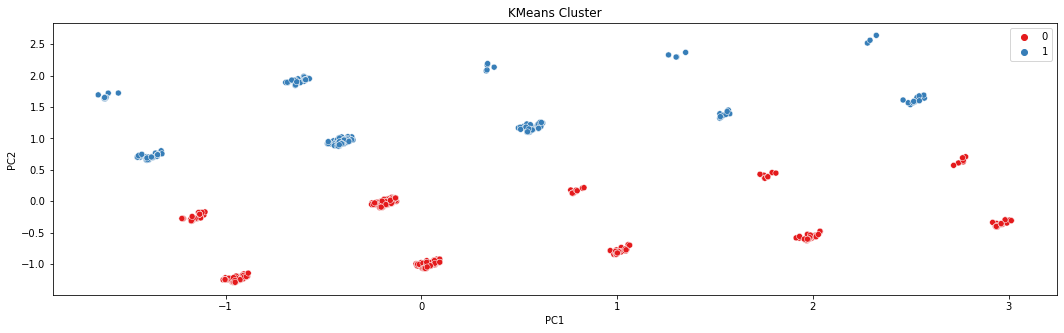

In [79]:
# Visualizing K-Means model.
plt.figure(figsize=(18,5))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=kmeans.labels_, palette='Set1')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('KMeans Cluster')
plt.show()

In [80]:
# Inputting Cluster output / definition into our original dataset.
df_kmeans = df1.copy()
df_kmeans['Risk'] = kmeans.labels_
df_kmeans.sort_values('Risk')

,No,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,none,little,14494431,6,radio/TV,0
465,465,63,male,2,own,little,little,36254676,24,car,0
466,466,29,female,1,rent,little,little,20569941,24,radio/TV,0
467,467,32,male,2,own,none,none,89743962,48,radio/TV,0
468,468,26,female,2,own,little,none,34270836,33,business,0
...,...,...,...,...,...,...,...,...,...,...,...
480,480,23,female,1,own,little,moderate,44301627,12,radio/TV,1
478,478,39,male,1,own,moderate,moderate,12857763,12,business,1
477,477,25,male,2,own,little,rich,63879648,24,radio/TV,1
470,470,22,male,2,rent,moderate,moderate,38337708,24,radio/TV,1


Class Balance:  0    668
1    332
Name: Risk, dtype: int64


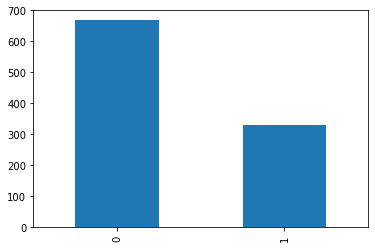

In [81]:
df_kmeans['Risk'].value_counts().plot(kind='bar')
print("Class Balance: ", df_kmeans['Risk'].value_counts())

Data Balance Interpretation:

- Ratio of 20 - 40% = Mild Imbalance 
- Ratio of 1 - 20% = Moderate Imbalance
- Ratio of Below 1% = Extreme Imbalance

In [38]:
print(332/(332+668)*100, '%') # There is a mild imbalance in our target value using KMeans.

33.2 %


## VII. Spectral Clustering

### a. Model Definition

In [41]:
# Defining the Spectral Clustering model.
spectral = SpectralClustering(n_clusters=2, random_state=42)

### b. Model Training

In [42]:
spectral.fit(X)

SpectralClustering(n_clusters=2, random_state=42)

### c. Model Evaluation

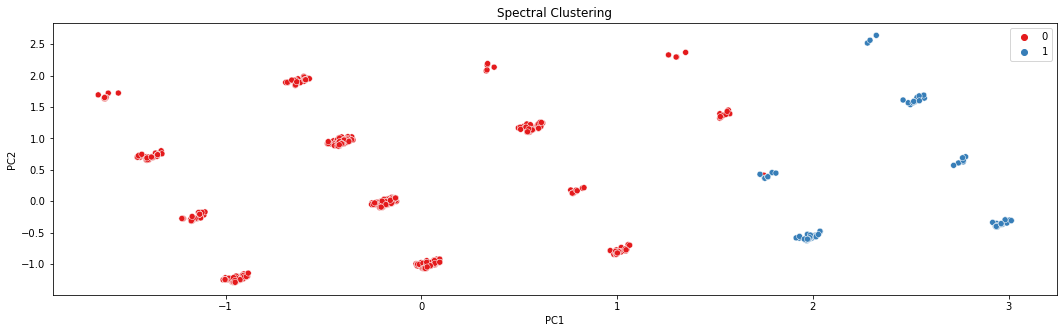

In [43]:
# Visualizing Spectral Clustering model.
plt.figure(figsize=(18,5))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=spectral.labels_, palette='Set1')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Spectral Clustering')
plt.show()

In [46]:
df_spec = df1.copy()
df_spec['Risk'] = spectral.labels_
df_spec.sort_values('Risk')

,No,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,none,little,14494431,6,radio/TV,0
639,639,26,male,2,own,little,little,54183630,42,radio/TV,0
640,640,27,female,0,own,little,little,9299250,18,education,0
641,641,38,male,1,own,little,moderate,16217892,15,repairs,0
642,642,40,male,3,own,moderate,none,57320577,15,education,0
...,...,...,...,...,...,...,...,...,...,...,...
567,567,34,male,2,own,rich,none,31964622,24,radio/TV,1
785,785,35,male,1,own,rich,moderate,24066459,18,business,1
786,786,40,male,2,own,quite rich,none,33167325,22,radio/TV,1
226,226,27,male,2,own,rich,moderate,135905439,48,radio/TV,1


Class Balance:  0    905
1     95
Name: Risk, dtype: int64


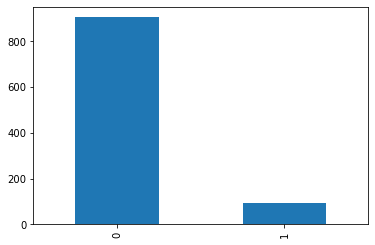

In [47]:
df_spec['Risk'].value_counts().plot(kind='bar')
print("Class Balance: ", df_spec['Risk'].value_counts())

In [119]:
print(95/(95+905)*100, '%') # There is a moderate imbalance in our target value using Spectral Clustering.

9.5 %


## VIII. BIRCH

### a. Model Definition

In [51]:
# Defining the BIRCH model.
birchclus = Birch(n_clusters=2)

### b. Model Training

In [52]:
birchclus.fit(X)

Birch(n_clusters=2)

### c. Model Evaluation

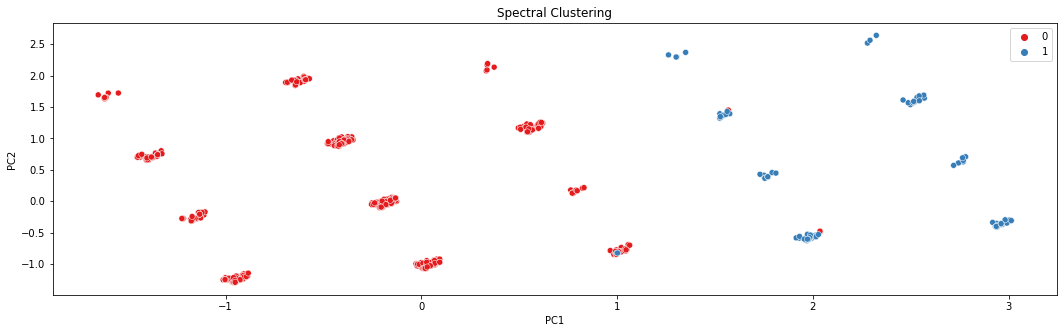

In [53]:
# Visualizing BIRCH model.
plt.figure(figsize=(18,5))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=birchclus.labels_, palette='Set1')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Spectral Clustering')
plt.show()

In [54]:
df_birch = df1.copy()
df_birch['Risk'] = birchclus.labels_
df_birch.sort_values('Risk')

,No,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,none,little,14494431,6,radio/TV,0
634,634,25,female,1,own,little,moderate,16800645,24,car,0
635,635,47,male,2,own,little,none,17271807,12,education,0
637,637,21,male,2,own,little,none,194081547,60,radio/TV,0
638,638,34,female,2,own,little,none,18511707,12,radio/TV,0
...,...,...,...,...,...,...,...,...,...,...,...
551,551,45,male,1,own,quite rich,none,21698250,6,radio/TV,1
399,399,43,female,1,own,rich,none,18796884,24,radio/TV,1
897,897,35,female,2,own,rich,none,19739208,12,furniture/equipment,1
391,391,19,female,1,rent,rich,moderate,12188217,12,furniture/equipment,1


Class Balance:  0    886
1    114
Name: Risk, dtype: int64


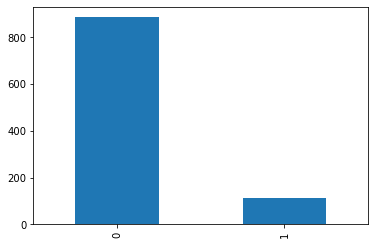

In [55]:
df_birch['Risk'].value_counts().plot(kind='bar')
print("Class Balance: ", df_birch['Risk'].value_counts())

In [120]:
print(114/(114+886)*100, '%') # There is a moderate imbalance in our target value using BIRCH.

11.4 %


## IX. Model Pipeline & Inference

### a. Pipeline

In [40]:
# Recombining Numerical and Categorical features for fitting of Pipeline.
df_pipe = pd.concat([df_num.reset_index(drop=True), df_ordinal.reset_index(drop=True), df_nominal.reset_index(drop=True)], axis=1)

# Creating individual Scaling and Encoding processes inside the Pipeline.
nominal_pipe = Pipeline([('nominal_encode',OneHotEncoder())])

ordinal_pipe = Pipeline([('ordinal_encode',OrdinalEncoder())])

num_pipe = Pipeline([('scaling',MinMaxScaler())])

# Redefining Numerical and the two different Categorical columns.
num_col = df_num.columns.values
nominal_cat_col = df_nominal.columns.values
ordinal_col = df_ordinal.columns.values

# Combining the processes into the final Pipeline.
preprocess = ColumnTransformer([
    ('nom',nominal_pipe,nominal_cat_col),
    ('num',num_pipe,num_col),
    ('ordinal',ordinal_pipe,ordinal_col)])
    
# Placing the Pipeline into a new definition and using best model.
pipe = Pipeline(steps=[("preprocess", preprocess), 
("model", KMeans(n_clusters=2, algorithm='lloyd', random_state=42))])

# Training / Fitting the combined Numerical and Categorical dataframe with the Pipeline.
pipe.fit(df_pipe)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nom',
                                                  Pipeline(steps=[('nominal_encode',
                                                                   OneHotEncoder())]),
                                                  array(['Sex', 'Housing', 'Purpose'], dtype=object)),
                                                 ('num',
                                                  Pipeline(steps=[('scaling',
                                                                   MinMaxScaler())]),
                                                  array(['Age', 'Credit amount', 'Duration'], dtype=object)),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ordinal_encode',
                                                                   OrdinalEncoder())]),
                                                  array(['Saving accounts', 'Checking account'], dtype=object))])),
                ('model', KMeans(n_clusters=2, random_state=42))])

### b. Inference

In [74]:
df1

,No,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,none,little,14494431,6,radio/TV
1,1,22,female,2,own,little,moderate,73786449,48,radio/TV
2,2,49,male,1,own,little,none,25988304,12,education
3,3,45,male,2,free,little,little,97728918,42,furniture/equipment
4,4,53,male,2,free,little,little,60383130,24,car
...,...,...,...,...,...,...,...,...,...,...
995,995,31,female,1,own,little,none,21524664,12,furniture/equipment
996,996,40,male,3,own,little,little,47822943,30,car
997,997,38,male,2,own,little,none,9968796,12,radio/TV
998,998,23,male,2,free,little,little,22876155,45,radio/TV


In [68]:
df1['Job'].unique()

array([2, 1, 3, 0], dtype=int64)

In [69]:
df1['Housing'].unique()

array(['own', 'free', 'rent'], dtype=object)

In [70]:
df1['Saving accounts'].unique()

array(['none', 'little', 'quite rich', 'rich', 'moderate'], dtype=object)

In [71]:
df1['Checking account'].unique()

array(['little', 'moderate', 'none', 'rich'], dtype=object)

In [72]:
df1['Purpose'].unique()

array(['radio/TV', 'education', 'furniture/equipment', 'car', 'business',
       'domestic appliances', 'repairs', 'vacation/others'], dtype=object)

In [86]:
# Dictionary for inference dataset.
inf = {'Age':[23, 25, 36, 41, 65], 
        'Sex':['male', 'female', 'male', 'male', 'male'],
        'Job':[3, 2, 3, 1, 0],
        'Housing':['free', 'own', 'free', 'rent', 'own'], 
        'Saving accounts':['none', 'quite rich', 'little', 'moderate', 'rich'], 
        'Checking account':['moderate', 'none', 'none', 'rich', 'little'],
        'Credit amount':[3099750, 39061530, 1166109, 28461900, 43575990], 
        'Duration':[36, 48, 2, 5, 20],
        'Purpose':['education', 'business', 'vacation/others', 'furniture/equipment', 'radio/TV']
}

In [87]:
# Creating inference dataset.
df_inf = pd.DataFrame.from_dict(inf)
df_inf

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,23,male,3,free,none,moderate,3099750,36,education
1,25,female,2,own,quite rich,none,39061530,48,business
2,36,male,3,free,little,none,1166109,2,vacation/others
3,41,male,1,rent,moderate,rich,28461900,5,furniture/equipment
4,65,male,0,own,rich,little,43575990,20,radio/TV


In [88]:
# Clustering / Segmentation of inference dataset.
pred_inf = pipe.predict(df_inf)
pred_inf = pd.DataFrame(pred_inf, columns = ['Risk'])
pd.concat([df_inf, pred_inf], axis=1)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,23,male,3,free,none,moderate,3099750,36,education,0
1,25,female,2,own,quite rich,none,39061530,48,business,0
2,36,male,3,free,little,none,1166109,2,vacation/others,1
3,41,male,1,rent,moderate,rich,28461900,5,furniture/equipment,1
4,65,male,0,own,rich,little,43575990,20,radio/TV,0


## X. Model Saving

In [89]:
# Saving our Preprocessing and Model Pipeline for use in deployment.
pickle.dump(pipe, open('risk_analysis.pkl', 'wb'))

## XI. Conclusion

In [92]:
df_risk = df_kmeans.copy()

In [93]:
df_risk.loc[df_risk['Risk']== 0, 'Risk'] = 'Bad'
df_risk.loc[df_risk['Risk']== 1, 'Risk'] = 'Good'

In [108]:
df_risk

,No,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,none,little,14494431,6,radio/TV,Bad
1,1,22,female,2,own,little,moderate,73786449,48,radio/TV,Good
2,2,49,male,1,own,little,none,25988304,12,education,Bad
3,3,45,male,2,free,little,little,97728918,42,furniture/equipment,Bad
4,4,53,male,2,free,little,little,60383130,24,car,Bad
...,...,...,...,...,...,...,...,...,...,...,...
995,995,31,female,1,own,little,none,21524664,12,furniture/equipment,Bad
996,996,40,male,3,own,little,little,47822943,30,car,Bad
997,997,38,male,2,own,little,none,9968796,12,radio/TV,Bad
998,998,23,male,2,free,little,little,22876155,45,radio/TV,Bad


### a. Numerical Features

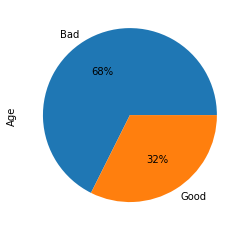

In [95]:
fig, ax = plt.subplots()
df_risk.groupby('Risk')['Age'].sum().plot(kind='pie', y='Class', autopct='%1.0f%%')
fig.patch.set_facecolor('xkcd:white')

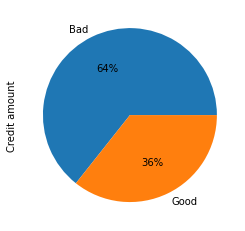

In [96]:
fig, ax = plt.subplots()
df_risk.groupby('Risk')['Credit amount'].sum().plot(kind='pie', y='Class', autopct='%1.0f%%')
fig.patch.set_facecolor('xkcd:white')

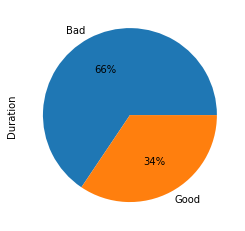

In [97]:
fig, ax = plt.subplots()
df_risk.groupby('Risk')['Duration'].sum().plot(kind='pie', y='Class', autopct='%1.0f%%')
fig.patch.set_facecolor('xkcd:white')

In [116]:
df_risk_bad = df_risk.loc[df_risk['Risk']== 'Bad']
df_risk_good = df_risk.loc[df_risk['Risk']== 'Good']

In [117]:
df_risk_bad.describe()

,Age,Job,Credit amount,Duration
count,668.000000,668.000000,6.680000e+02,668.000000
mean,35.980539,1.917665,3.906153e+07,20.522455
std,11.365058,0.615238,3.206785e+07,11.467356
min,19.000000,0.000000,3.099750e+06,4.000000
25%,27.000000,2.000000,1.717262e+07,12.000000
50%,34.000000,2.000000,2.846190e+07,18.000000
75%,43.000000,2.000000,4.784154e+07,24.000000
max,75.000000,3.000000,1.966109e+08,60.000000


In [118]:
df_risk_good.describe()

,Age,Job,Credit amount,Duration
count,332.000000,332.000000,3.320000e+02,332.000000
mean,34.671687,1.876506,4.357599e+07,21.668675
std,11.363164,0.724906,4.013896e+07,13.153469
min,19.000000,0.000000,3.422124e+06,4.000000
25%,26.000000,1.000000,1.637908e+07,12.000000
50%,32.000000,2.000000,2.895166e+07,18.000000
75%,40.000000,2.000000,5.344589e+07,27.750000
max,74.000000,3.000000,2.284392e+08,72.000000


The age, job description, credit amount, and duration has little-to-no direct correlation with the segmentation of the potential loanees.

### b. Categorical Features

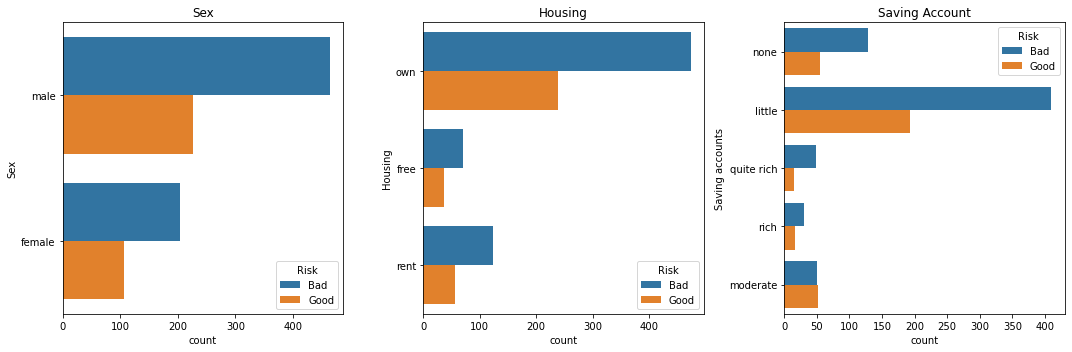

In [98]:
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
sns.countplot(hue = 'Risk', y = 'Sex', data=df_risk, palette="tab10")
plt.title('Sex')

plt.subplot(1,4,2)
sns.countplot(hue = 'Risk', y = 'Housing', data=df_risk, palette="tab10")
plt.title('Housing')

plt.subplot(1,4,3)
sns.countplot(hue = 'Risk', y = 'Saving accounts', data=df_risk, palette="tab10")
plt.title('Saving Account')

plt.tight_layout()
plt.show()

In the case for housing, there is a high probability that persons that own a house would still have mortgage responsibilities to pay off. Therefore, their financial strength is limited. Hence, there is more risk to loan financial aid to them. 

Saving account is the first indication of financial security of an individual. If they have none-to-little, their financial strength is weak, and if they have quite rich to rich, then this would most likely meant they have accounts elsewhere that would hinder in the analysis of their true financial situation. Moderate has a balanced ratio, which would give the best indication of a loanee's financial strength due to the high probability that they would most likely have the one account.

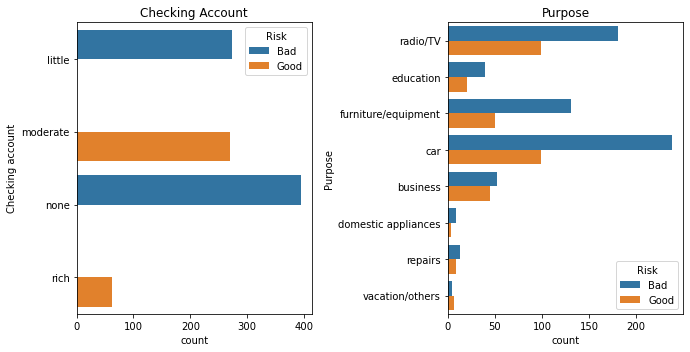

In [99]:
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
sns.countplot(hue = 'Risk', y = 'Checking account', data=df_risk, palette="tab10")
plt.title('Checking Account')

plt.subplot(1,4,2)
sns.countplot(hue = 'Risk', y = 'Purpose', data=df_risk, palette="tab10")
plt.title('Purpose')

plt.tight_layout()
plt.show()

A checking account would be the best indicator for a good and bad loan deal, where a level of none-to-little would indicate that the loan is risky, whilst a level of moderate-to-rich would indicate that the loan has lesser risk. 

If the loan is used to pay off depreciating assets, then it would be a riskier move compared to a loan that has a potential return of investment. In addition, short-term, low amount loans would also be more ideal than that of depreciating assets. In this case, radio/TV, furniture/equipment, and domestic appliances would be depreciating assets, hence risky loans. Education and business would is more likely to have a return of investment, hence is less risky. Vacation too would be less risky since it is a short-term, low amount loan.